In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=5d416ac29715a969a03ce161ada91f910225bdc34f6bd823f526a82f76e487ca
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sqrt, pow
# Spark session
spark = SparkSession.builder \
    .appName("EuclideanDistance") \
    .getOrCreate()
# heart rate readings (bpm) from fitbit
data = [
    (1, 72),  # User 1, Heart Rate: 72 bpm
    (2, 85),  # User 2, Heart Rate: 85 bpm
    (3, 90),  # User 3, Heart Rate: 90 bpm
    (4, 78),  # User 4, Heart Rate: 78 bpm
]
columns = ["UserID", "HeartRate"]
df = spark.createDataFrame(data, columns)
reference_heart_rate = 80
# Calculate Euclidean distance for each user
df_with_distance = df.withColumn("EuclideanDistance",
    sqrt(pow(col("HeartRate") - reference_heart_rate, 2))
)
df_with_distance.show()

spark.stop()

+------+---------+-----------------+
|UserID|HeartRate|EuclideanDistance|
+------+---------+-----------------+
|     1|       72|              8.0|
|     2|       85|              5.0|
|     3|       90|             10.0|
|     4|       78|              2.0|
+------+---------+-----------------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sqrt, expr, array, lit, size

# Initialize Spark session
spark = SparkSession.builder.appName("CosineSimilarityExample").getOrCreate()

# Sample data: user ratings for movies
data = [
    (1, [5, 3, 0, 0, 2]),  # User 1's ratings
    (2, [4, 0, 0, 2, 5]),  # User 2's ratings
    (3, [0, 0, 5, 3, 0]),  # User 3's ratings
    (4, [0, 3, 4, 0, 0]),  # User 4's ratings
]

# Create DataFrame
df = spark.createDataFrame(data, ["user_id", "ratings"])

# Function to calculate cosine similarity
def cosine_similarity(ratings):
    norm = sqrt(sum(col("ratings")[i]**2 for i in range(len(ratings))))
    similarity = expr("aggregate(transform(ratings, x -> x * x), 0D, (acc, x) -> acc + x) / (norm * norm)")
    return similarity

# Normalize the ratings
df = df.withColumn("norm", sqrt(expr("aggregate(ratings, 0D, (acc, x) -> acc + x * x)")))
df = df.withColumn("normalized_ratings", expr("transform(ratings, x -> x / norm)"))

# Create a cross join to compare every user with every other user
cross_df = df.alias("a").crossJoin(df.alias("b"))

# Calculate cosine similarity between users
similarity_df = cross_df.select(
    col("a.user_id").alias("user_a"),
    col("b.user_id").alias("user_b"),
    expr("aggregate(transform(zip_with(a.normalized_ratings, b.normalized_ratings, (x, y) -> x * y), x -> x), 0D, (acc, x) -> acc + x)").alias("cosine_similarity")
)

# Show the cosine similarity results
similarity_df.show()

# Recommendations based on similarity (example)
# This part can be further customized based on the similarity scores
recommendations = similarity_df.filter(col("cosine_similarity") > 0.5)  # Example threshold for recommendations
recommendations.show()

# Stop Spark session
spark.stop()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sqrt, expr, array, lit, size

spark = SparkSession.builder.appName("CosineSimilarityExample").getOrCreate()
data = [
    (1, [5, 3, 0, 0, 2]),  # User 1's movie ratings
    (2, [4, 0, 0, 2, 5]),  # User 2's movie ratings
    (3, [0, 0, 5, 3, 0]),  # User 3's movie ratings
    (4, [0, 3, 4, 0, 0]),  # User 4's movie ratings
]
df = spark.createDataFrame(data, ["user_id", "ratings"])
# Function to calculate cosine similarity
def cosine_similarity(ratings):
    norm = sqrt(sum(col("ratings")[i]**2 for i in range(len(ratings))))
    similarity = expr("aggregate(transform(ratings, x -> x * x), 0D, (acc, x) -> acc + x) / (norm * norm)")
    return similarity
df = df.withColumn("norm", sqrt(expr("aggregate(ratings, 0D, (acc, x) -> acc + x * x)")))
df = df.withColumn("normalized_ratings", expr("transform(ratings, x -> x / norm)"))
# compare every user with every other user
cross_df = df.alias("a").crossJoin(df.alias("b"))
# calculate cosine similarity between users
similarity_df = cross_df.select(
    col("a.user_id").alias("user_a"),
    col("b.user_id").alias("user_b"),
    expr("aggregate(transform(zip_with(a.normalized_ratings, b.normalized_ratings, (x, y) -> x * y), x -> x), 0D, (acc, x) -> acc + x)").alias("cosine_similarity")
)
similarity_df.show()
recommendations = similarity_df.filter(col("cosine_similarity") > 0.5)  # Example threshold for recommendations
recommendations.show()
spark.stop()

+------+------+-------------------+
|user_a|user_b|  cosine_similarity|
+------+------+-------------------+
|     1|     1| 1.0000000000000002|
|     1|     2| 0.7254762501100117|
|     2|     1| 0.7254762501100117|
|     2|     2|                1.0|
|     1|     3|                0.0|
|     1|     4|0.29199855803537256|
|     2|     3|0.15339299776947407|
|     2|     4|                0.0|
|     3|     1|                0.0|
|     3|     2|0.15339299776947407|
|     4|     1|0.29199855803537256|
|     4|     2|                0.0|
|     3|     3| 0.9999999999999998|
|     3|     4| 0.6859943405700353|
|     4|     3| 0.6859943405700353|
|     4|     4|                1.0|
+------+------+-------------------+

+------+------+------------------+
|user_a|user_b| cosine_similarity|
+------+------+------------------+
|     1|     1|1.0000000000000002|
|     1|     2|0.7254762501100117|
|     2|     1|0.7254762501100117|
|     2|     2|               1.0|
|     3|     3|0.9999999999999998|

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, size, expr, array_intersect, array_union
spark = SparkSession.builder.appName("JaccardSimilarityHobbies").getOrCreate()
data = [
    (1, ["Reading", "Traveling", "Hiking"]),  # User 1's hobbies
    (2, ["Traveling", "Painting", "Cooking"]),  # User 2's hobbies
    (3, ["Hiking", "Reading", "Cooking"]),       # User 3's hobbies
    (4, ["Reading", "Traveling"])                 # User 4's hobbies
]
df = spark.createDataFrame(data, ["user", "hobbies"])
df.createOrReplaceTempView("user_hobbies")
# Calculate Jaccard Similarity
jaccard_similarity_query = """
SELECT
    a.user AS user_a,
    b.user AS user_b,
    size(array_intersect(a.hobbies, b.hobbies)) / size(array_union(a.hobbies, b.hobbies)) AS jaccard_similarity
FROM user_hobbies a
JOIN user_hobbies b ON a.user < b.user
"""
jaccard_similarity_df = spark.sql(jaccard_similarity_query)
jaccard_similarity_df.show()

+------+------+------------------+
|user_a|user_b|jaccard_similarity|
+------+------+------------------+
|     1|     2|               0.2|
|     1|     3|               0.5|
|     1|     4|0.6666666666666666|
|     2|     3|               0.2|
|     2|     4|              0.25|
|     3|     4|              0.25|
+------+------+------------------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, corr
spark = SparkSession.builder.appName("PearsonCorrelationPsychology").getOrCreate()
# data representing stress levels and coping strategy ratings
data = [
    (1, 7, 3),  # Participant 1
    (2, 5, 6),  # Participant 2
    (3, 4, 7),  # Participant 3
    (4, 8, 2),  # Participant 4
    (5, 3, 8)   # Participant 5
]
df = spark.createDataFrame(data, ["participant", "stress_level", "coping_strategy_rating"])

# Calculate Pearson correlation between anxiety levels and coping strategy ratings
correlation_df = df.select(corr("stress_level", "coping_strategy_rating").alias("pearson_correlation"))
correlation_df.show()

+-------------------+
|pearson_correlation|
+-------------------+
|-0.9967406097425906|
+-------------------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
spark = SparkSession.builder.appName("SpearmanRankCorrelation").getOrCreate()
data = [
    (1, 5, 80),
    (2, 3, 65),
    (3, 4, 75),
    (4, 2, 55),
    (5, 1, 45)
]
df = spark.createDataFrame(data, ["StudentID", "HoursStudied", "ExamScore"])
# ranks for Hours Studied and Exam Scores
df = df.withColumn("HoursRank", F.rank().over(Window.orderBy("HoursStudied"))) \
       .withColumn("ScoreRank", F.rank().over(Window.orderBy("ExamScore")))
# rank differences and their squares
df = df.withColumn("RankDifference", F.col("HoursRank") - F.col("ScoreRank")) \
       .withColumn("RankDifferenceSquared", F.pow(F.col("RankDifference"), 2))
# Spearman Rank Correlation
n = df.count()
sum_d_squared = df.agg(F.sum("RankDifferenceSquared")).collect()[0][0]
# Spearman correlation coefficient
spearman_corr = 1 - (6 * sum_d_squared) / (n * (n**2 - 1))
print("Spearman Rank Correlation Coefficient:", spearman_corr)

Spearman Rank Correlation Coefficient: 1.0


In [ ]:
import numpy as np
import scipy.stats as stats

# Observed data
observed = np.array([[40, 10], [50, 20]])

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(observed)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies: \n", expected)

Chi-square statistic: 0.7314285714285714
P-value: 0.3924205244765816
Degrees of freedom: 1
Expected frequencies: 
 [[37.5 12.5]
 [52.5 17.5]]


In [ ]:
import numpy as np
import scipy.stats as stats

observed_data = np.array([[30, 20],  # Male
                          [40, 10]])  # Female

# Perform the Chi-square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(observed_data)

print(f"Chi-square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print("Expected frequencies (if no association between gender and preference):")
print(expected)

Chi-square Statistic: 3.8571428571428577
P-value: 0.04953461343562649
Degrees of Freedom: 1
Expected frequencies (if no association between gender and preference):
[[35. 15.]
 [35. 15.]]


In [ ]:
import numpy as np
import scipy.stats as stats

# Test scores for two different study techniques
technique_x = np.array([88, 92, 95, 87, 90])  # Scores using Technique X
technique_y = np.array([78, 82, 80, 76, 74])  # Scores using Technique Y

# Perform the independent T-test
t_stat, p_value = stats.ttest_ind(technique_x, technique_y)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 6.15401667061977
P-value: 0.0002727930659047754


In [ ]:
import numpy as np
import scipy.stats as stats

# Movie ratings for two different genres
action_ratings = np.array([7.5, 8.0, 8.5, 7.0, 9.0])  # Ratings for Action movies
romance_ratings = np.array([6.5, 7.0, 9.5, 7.5, 8.0, 6.0])  # Ratings for Romance movies

# Perform the F-test for equality of variances using the F-test
f_stat, p_value = stats.levene(action_ratings, romance_ratings)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 0.6966123499142365
P-value: 0.425523474329078


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import io
from google.colab import files
from skimage.io import imread
from skimage.transform import resize

# Upload the image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]


Saving Flower Image for segmentation.jpg to Flower Image for segmentation.jpg


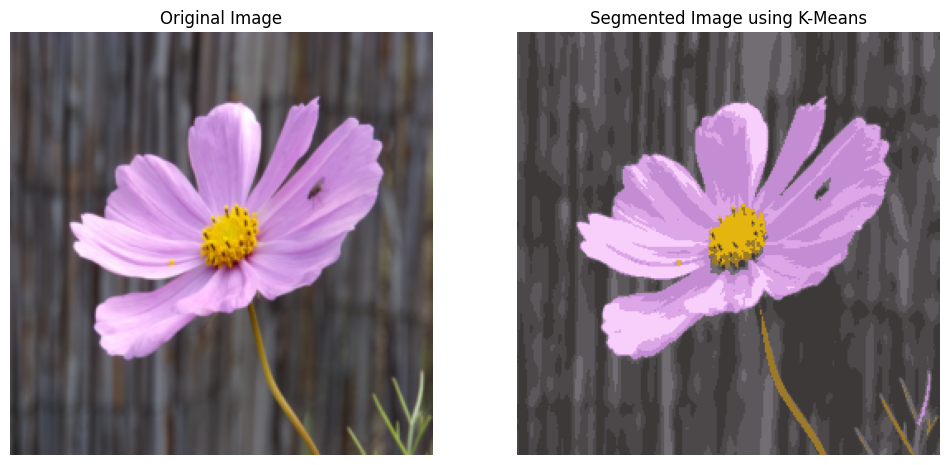

In [ ]:
image = imread(image_path)

# Convert the image to RGB
if image.shape[2] == 4:
    image = image[..., :3]

image = resize(image, (256, 256), anti_aliasing=True)

# Reshape the image to a 2D array of pixels
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# number of clusters (K)
K = 9
kmeans = KMeans(n_clusters=K, random_state=42)

kmeans.fit(pixel_values)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

centroids = np.uint8(centroids * 255)

# reshape the segmented image
segmented_image = centroids[labels].reshape(image.shape)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title('Segmented Image using K-Means')
plt.axis('off')

plt.show()

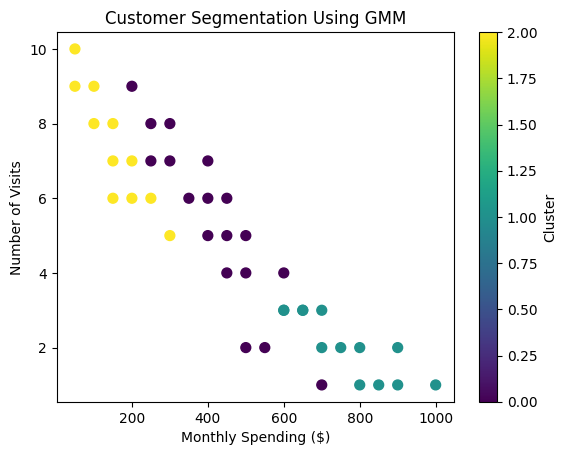

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Customer data: [monthly spending, number of visits]
customer_data = np.array([
    [500, 2], [600, 3], [800, 1], [300, 5], [200, 7], [250, 6],
    [700, 1], [500, 4], [650, 3], [100, 8], [150, 6], [550, 2],
    [400, 5], [450, 4], [850, 1], [750, 2], [300, 7], [200, 6],
    [400, 6], [1000, 1], [900, 2], [700, 3], [600, 4], [450, 5],
    [50, 9], [150, 7], [250, 8], [900, 1], [800, 2], [700, 2],
    [500, 5], [300, 8], [600, 3], [400, 7], [350, 6], [200, 9],
    [650, 3], [450, 6], [100, 9], [50, 10], [150, 8], [250, 7]
])

# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(customer_data)

# Predict the cluster for each customer
labels = gmm.predict(customer_data)

# Plot the results
plt.scatter(customer_data[:, 0], customer_data[:, 1], c=labels, s=50, cmap='viridis')
plt.xlabel('Monthly Spending ($)')
plt.ylabel('Number of Visits')
plt.title('Customer Segmentation Using GMM')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
# Install necessary libraries
!pip install pyspark numpy Pillow matplotlib

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.clustering import BisectingKMeans
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

# Upload the image
uploaded = files.upload()
image_path = next(iter(uploaded))  # Get the uploaded image filename



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=14614ab9cb3d48dbe87e434420ba0d6bd0e4b9660ef238e4a4801037a89ed567
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


Saving colorful flowers.jpg to colorful flowers.jpg


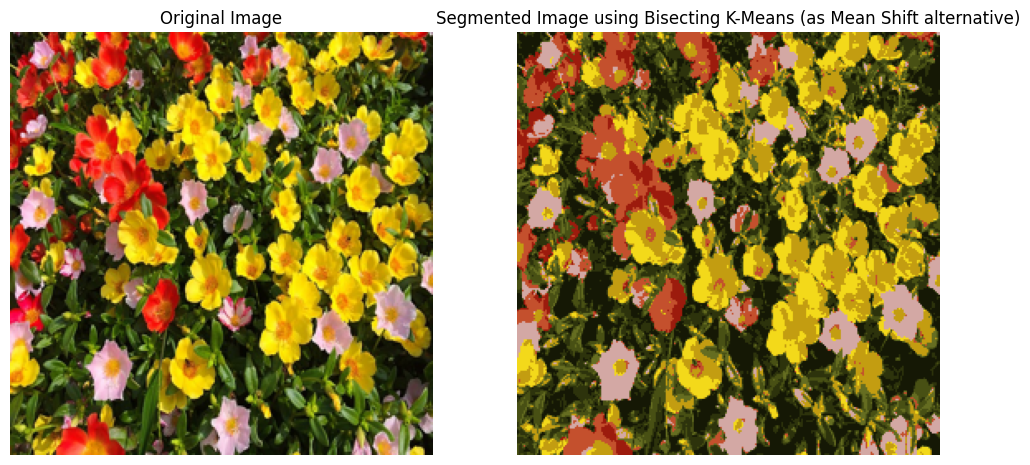

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import VectorAssembler
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Mean Shift Image Segmentation") \
    .getOrCreate()

# Load the image
image = Image.open(image_path)

# Convert image to RGB if it has an alpha channel
if image.mode == 'RGBA':
    image = image.convert('RGB')

# Resize the image for faster processing if needed
image = image.resize((256, 256))

# Convert the image to a NumPy array and reshape it to 2D
pixel_values = np.array(image).reshape(-1, 3)

# Convert pixel values to a DataFrame
pixel_df = spark.createDataFrame(pixel_values.tolist(), ["R", "G", "B"])

# Assemble the RGB columns into a feature vector
vector_assembler = VectorAssembler(inputCols=["R", "G", "B"], outputCol="features")
pixel_df = vector_assembler.transform(pixel_df)

# Apply Bisecting K-Means as a substitute for Mean Shift
k = 9  # You can change this value to experiment with different cluster numbers
bkm = BisectingKMeans(k=k, maxIter=10, featuresCol="features")
model = bkm.fit(pixel_df)

# Get the cluster centers
centers = model.clusterCenters()

# Assign cluster labels to the pixel data
predictions = model.transform(pixel_df)

# Convert predictions back to an image
segmented_pixels = np.zeros_like(pixel_values)
predicted_labels = predictions.select("prediction").toPandas().values.flatten()
for i, center in enumerate(centers):
    segmented_pixels[predicted_labels == i] = center

# Reshape back to the original image shape
segmented_image = segmented_pixels.reshape(image.size[1], image.size[0], 3).astype(np.uint8)

# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title('Segmented Image using Bisecting K-Means (as Mean Shift alternative)')
plt.axis('off')

plt.show()

# Stop the Spark session
spark.stop()

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from skimage import io

# Load the image (Make sure you upload your image in Colab or specify the path if running locally)
from google.colab import files
uploaded = files.upload()  # Upload your image here

# Load the image using skimage.io
image = io.imread(list(uploaded.keys())[0])

# Convert the image to RGB if it's not already
if image.shape[2] == 4:  # In case the image has an alpha channel (RGBA)
    image = image[..., :3]

# Reshape the image to a 2D array of pixels (each pixel is represented by its RGB values)
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# Apply Mean Shift clustering
mean_shift = MeanShift(bandwidth=30)  # You can adjust the bandwidth parameter for different results
mean_shift.fit(pixel_values)

# Get the labels and cluster centers
labels = mean_shift.labels_
cluster_centers = mean_shift.cluster_centers_

# Convert centroids to uint8 (valid pixel values) and reshape the segmented image
segmented_image = cluster_centers[labels].reshape(image.shape).astype('uint8')

# Plot the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title('Segmented Image using Mean Shift')
plt.axis('off')

plt.show()


Saving colorful flowers.jpg to colorful flowers (1).jpg


KeyboardInterrupt: 

Saving flower-seed-mixtures-640-300x300.jpg to flower-seed-mixtures-640-300x300.jpg


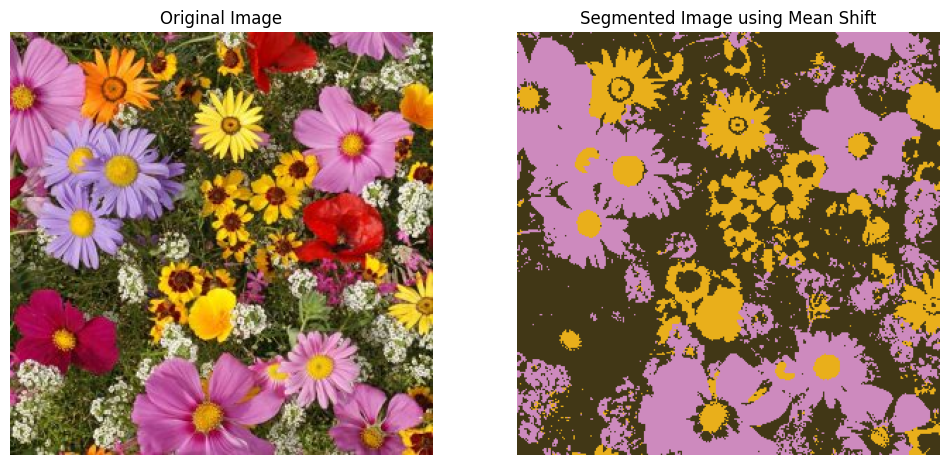

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from skimage import io
from google.colab import files
from PIL import Image

# Upload an image
uploaded = files.upload()

# Load the image using PIL
image_path = list(uploaded.keys())[0]  # Get the file name of the uploaded image
image = Image.open(image_path)
image = np.array(image)

# Convert the image to RGB if it contains an alpha channel (RGBA)
if image.shape[2] == 4:
    image = image[..., :3]

# Reshape the image to a 2D array of pixels (each pixel is represented by its RGB values)
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# Apply Mean Shift clustering with a defined bandwidth
bandwidth = 50  # Adjust this value to optimize the speed and result
mean_shift = MeanShift(bandwidth=bandwidth)
mean_shift.fit(pixel_values)

# Get the labels and cluster centers (centroids)
labels = mean_shift.labels_
cluster_centers = mean_shift.cluster_centers_

# Convert cluster centers to uint8 and reshape the segmented image
segmented_image = cluster_centers[labels].reshape(image.shape).astype('uint8')

# Plot the original and segmented images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title('Segmented Image using Mean Shift')
plt.axis('off')

plt.show()